<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Hyperparameter tuning (Spark based recommender)

Hyperparameter tuning for Spark based recommender algorithm is important to select a model with the optimal performance. This notebook introduces good practices in performing hyperparameter tuning for building recommender models with the utility functions provided in the [Microsoft/Recommenders](https://github.com/Microsoft/Recommenders.git) repository.

Three different approaches are introduced and comparatively studied.
* Spark native/custom constructs (`ParamGridBuilder`, `TrainValidationSplit`).
* `hyperopt` package with Tree of Parzen Estimator algorithm. 
* Brute-force random search of parameter values sampled with pre-defined space. 

## 0 Global settings and import

In [15]:
# set the environment path to find Recommenders
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
import pandas as pd
import numpy as np
import time

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark import SparkContext, SparkConf
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import Evaluator, RegressionEvaluator
from pyspark.ml.pipeline import Estimator, Model
from pyspark import keyword_only  
from pyspark.ml import Transformer
from pyspark.ml.param.shared import *
from pyspark.ml.util import *
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.sql.types import ArrayType, IntegerType, StringType

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

from reco_utils.common.spark_utils import start_or_get_spark
from reco_utils.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from reco_utils.dataset.movielens import load_spark_df
from reco_utils.dataset.spark_splitters import spark_random_split

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("PySpark version: {}".format(pyspark.__version__))

System version: 3.5.5 |Anaconda custom (64-bit)| (default, May 13 2018, 21:12:35) 
[GCC 7.2.0]
Pandas version: 0.23.0
PySpark version: 2.3.1


In [16]:
NUMBER_CORES = 1
NUMBER_ITERATIONS = 25

COL_USER = "userID"
COL_ITEM = "itemID"
COL_TIMESTAMP = "timestamp"
COL_RATING = "rating"
COL_PREDICTION = "prediction"

HEADER = {
    "col_user": COL_USER,
    "col_item": COL_ITEM,
    "col_rating": COL_RATING,
    "col_prediction": COL_PREDICTION,
}

HEADER_ALS = {
    "userCol": COL_USER,
    "itemCol": COL_ITEM,
    "ratingCol": COL_RATING
}

RANK = [10, 15, 20, 30, 40]
REG = [ 0.1, 0.01, 0.001, 0.0001, 0.00001]

## 1 Data preparation

A Spark session is created. Note in this case, to study the running time for different approaches, the Spark session in local mode uses only one core for running. This eliminates the impact of parallelization of parameter tuning. 

In [17]:
spark = start_or_get_spark(url="local[{}]".format(NUMBER_CORES))

MovieLens 100k dataset is used for running the demonstration.

In [18]:
data = load_spark_df(spark, size='100k', header=(COL_USER, COL_ITEM, COL_RATING))

100%|██████████| 4.81k/4.81k [00:01<00:00, 2.48kKB/s]


To reduce time spent on the comparitive study, 50% of the data is used for the experimentation below.

In [19]:
data, _ = spark_random_split(data, ratio=0.5)

The dataset is split into 3 subsets randomly with a given split ratio. The hyperparameter tuning is performed on the training and the validating data, and then the optimal recommender selected is evaluated on the testing dataset.

In [20]:
train, valid, test = spark_random_split(data, ratio=[3, 1, 1])

## 2 Hyper parameter tuning with Azure Machine Learning Services

The `hyperdrive` module in the [Azure Machine Learning Services](https://azure.microsoft.com/en-us/services/machine-learning-service/) runs [hyperparameter tuning and optimizing for machine learning model selection](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-tune-hyperparameters). At the moment, the service supports running hyperparameter tuning on heterogenous computing targets such as cluster of commodity compute nodes with or without GPU devices (see detailed documentation [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets)). It is feasible to run parameter tuning on a cluster of VM nodes. In this case, the service containerizes individual and independent Spark session on each node of the cluster to run the parameter tuning job in parallel, instead of inside a single Spark session where the training is executed in a distributed manner.  

Detailed instructions of tuning hyperparameter of non-Spark workloads by using Azure Machine Learning Services can be found in [this](./hypertune_aml_wide_and_deep_quickstart.ipynb) notebook. 

## 3 Hyper parameter tuning with Spark ML constructs

### 3.1 Spark native construct

Spark ML lib implements modules such as `CrossValidator` and `TrainValidationSplit` for tuning hyperparameters (see [here](https://spark.apache.org/docs/2.2.0/ml-tuning.html)). However, by default, it does not support custom machine learning algorithms, data splitting methods, and evaluation metrics, like what are offered as utility functions in the Recommenders repository. 

For example, the Spark native constuct can be used for tuning a recommender against the `rmse` metric which is one of the available regression metrics in Spark.

Firstly, a Spark ALS object needs to be created. In this case, for illustration purpose, it is an ALS model object.

In [21]:
# NOTE the parameters of interest, rank and regParam, are left unset, 
# because their values will be assigned in the parameter grid builder.
als = ALS(
    maxIter=15,
    implicitPrefs=False,
    alpha=0.1,
    coldStartStrategy='drop',
    nonnegative=False,
    **HEADER_ALS
)

Then, a parameter grid can be defined as follows. Without loss of generity, only `rank` and `regParam` are considered.

In [22]:
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, RANK) \
    .addGrid(als.regParam, REG) \
    .build()

Given the settings above, a `TrainValidationSplit` constructor can be created for fitting the best model in the given parameter range. In this case, the `RegressionEvaluator` is using `RMSE`, by default, as an evaluation metric. 

Since the data splitter is embedded in the `TrainValidationSplit` object, to make sure the splitting ratio is consistent across different approaches, the split ratio is set to be 0.75 and in the model training the training dataset and validating dataset are combined. 

In [23]:
tvs = TrainValidationSplit(
    estimator=als,
    estimatorParamMaps=paramGrid,
    # A regression evaluation method is used. 
    evaluator=RegressionEvaluator(labelCol='rating'),
    # 75% of the data will be used for training, 25% for validation.
    # NOTE here the splitting is random. The Spark splitting utilities (e.g. chrono splitter)
    # are therefore not available here. 
    trainRatio=0.75
)

In [24]:
time_start = time.time()

# Run TrainValidationSplit, and choose the best set of parameters.
# NOTE train and valid is union because in Spark TrainValidationSplit does splitting by itself.
model = tvs.fit(train.union(valid))

time_spark = time.time() - time_start

The model parameters in the grid and the best metrics can be then returned. 

In [25]:
for idx, item in enumerate(model.getEstimatorParamMaps()):
    print('Run {}:'.format(idx))
    print('\tValidation Metric: {}'.format(model.validationMetrics[idx]))
    for key, value in item.items():
        print('\t{0}: {1}'.format(repr(key), value))

Run 0:
	Validation Metric: 1.0441868958989502
	Param(parent='ALS_4e5c95ed85bdac011aff', name='regParam', doc='regularization parameter (>= 0).'): 0.1
	Param(parent='ALS_4e5c95ed85bdac011aff', name='rank', doc='rank of the factorization'): 10
Run 1:
	Validation Metric: 1.0428702749684167
	Param(parent='ALS_4e5c95ed85bdac011aff', name='regParam', doc='regularization parameter (>= 0).'): 0.1
	Param(parent='ALS_4e5c95ed85bdac011aff', name='rank', doc='rank of the factorization'): 15
Run 2:
	Validation Metric: 1.0396751902892425
	Param(parent='ALS_4e5c95ed85bdac011aff', name='regParam', doc='regularization parameter (>= 0).'): 0.1
	Param(parent='ALS_4e5c95ed85bdac011aff', name='rank', doc='rank of the factorization'): 20
Run 3:
	Validation Metric: 1.026766260437336
	Param(parent='ALS_4e5c95ed85bdac011aff', name='regParam', doc='regularization parameter (>= 0).'): 0.1
	Param(parent='ALS_4e5c95ed85bdac011aff', name='rank', doc='rank of the factorization'): 30
Run 4:
	Validation Metric: 1.0241

In [26]:
model.validationMetrics

[1.0441868958989502,
 1.0428702749684167,
 1.0396751902892425,
 1.026766260437336,
 1.0241188528887704,
 1.4389645123055679,
 1.4846022039123894,
 1.4321515055336882,
 1.3840873927606863,
 1.3311786541262227,
 1.919301654712844,
 1.9084981505110143,
 1.9488323899836721,
 1.881972151998,
 1.916657689890733,
 2.767206740205072,
 2.642671648814952,
 2.8407773780926697,
 2.614567482844518,
 3.13604532549834,
 3.7788772423670722,
 3.8708770148426628,
 3.9825787165316076,
 3.615288962671175,
 4.447600051061981]

To get the best model, just do

In [27]:
model_best_spark = model.bestModel

### 3.2 Custom `Estimator`, `Transformer`, and `Evaluator` for Spark ALS

One can also customize Spark modules to allow tuning hyperparameters for a desired model and evaluation metric, given that the native Spark ALS does not allow tuning hyperparameters for ranking metrics such as precision@k, recall@k, etc. This can be done by creating custom `Estimator`, `Transformer` and `Evaluator`. The benefit is that, after the customization, the tuning process can make use of `trainValidSplit` directly, which distributes the tuning in a Spark session.

#### Customized `Estimator` and `Transformer` for top k recommender based on Spark ALS

The following shows how to implement a PySpark `Estimator` and `Transfomer` for recommending top k items from ALS model. The latter generates top k recommendations from the model object. Both of the two are designed by following the protocol of Spark APIs, to make sure that they can be run with the hyperparameter tuning constructs in Spark.

In [28]:
class ALSTopK(
    ALS,
    Estimator,
    HasInputCol,
    HasPredictionCol
):    
    rank = Param(Params._dummy(), "rank", "rank of the factorization",
                 typeConverter=TypeConverters.toInt)
    numUserBlocks = Param(Params._dummy(), "numUserBlocks", "number of user blocks",
                          typeConverter=TypeConverters.toInt)
    numItemBlocks = Param(Params._dummy(), "numItemBlocks", "number of item blocks",
                          typeConverter=TypeConverters.toInt)
    implicitPrefs = Param(Params._dummy(), "implicitPrefs", "whether to use implicit preference",
                          typeConverter=TypeConverters.toBoolean)
    alpha = Param(Params._dummy(), "alpha", "alpha for implicit preference",
                  typeConverter=TypeConverters.toFloat)
    userCol = Param(Params._dummy(), "userCol", "column name for user ids. Ids must be within " +
                    "the integer value range.", typeConverter=TypeConverters.toString)
    itemCol = Param(Params._dummy(), "itemCol", "column name for item ids. Ids must be within " +
                    "the integer value range.", typeConverter=TypeConverters.toString)
    ratingCol = Param(Params._dummy(), "ratingCol", "column name for ratings",
                      typeConverter=TypeConverters.toString)
    nonnegative = Param(Params._dummy(), "nonnegative",
                        "whether to use nonnegative constraint for least squares",
                        typeConverter=TypeConverters.toBoolean)
    intermediateStorageLevel = Param(Params._dummy(), "intermediateStorageLevel",
                                     "StorageLevel for intermediate datasets. Cannot be 'NONE'.",
                                     typeConverter=TypeConverters.toString)
    finalStorageLevel = Param(Params._dummy(), "finalStorageLevel",
                              "StorageLevel for ALS model factors.",
                              typeConverter=TypeConverters.toString)
    coldStartStrategy = Param(Params._dummy(), "coldStartStrategy", "strategy for dealing with " +
                              "unknown or new users/items at prediction time. This may be useful " +
                              "in cross-validation or production scenarios, for handling " +
                              "user/item ids the model has not seen in the training data. " +
                              "Supported values: 'nan', 'drop'.",
                              typeConverter=TypeConverters.toString)

    @keyword_only
    def __init__(
        self,
        rank=10, maxIter=10, regParam=0.1, numUserBlocks=10, numItemBlocks=10,
        implicitPrefs=False, alpha=1.0, userCol="user", itemCol="item", seed=None, k=10,
        ratingCol="rating", nonnegative=False, checkpointInterval=10,
        intermediateStorageLevel="MEMORY_AND_DISK",
        finalStorageLevel="MEMORY_AND_DISK", coldStartStrategy="nan"
    ):
        super(ALS, self).__init__()
        self._java_obj = self._new_java_obj("org.apache.spark.ml.recommendation.ALS", self.uid)
        self._setDefault(rank=10, maxIter=10, regParam=0.1, numUserBlocks=10, numItemBlocks=10,
                         implicitPrefs=False, alpha=1.0, userCol="user", itemCol="item",
                         ratingCol="rating", nonnegative=False, checkpointInterval=10,
                         intermediateStorageLevel="MEMORY_AND_DISK",
                         finalStorageLevel="MEMORY_AND_DISK", coldStartStrategy="nan")

        kwargs = self._input_kwargs 
        kwargs = {x: kwargs[x] for x in kwargs if x not in {'k'}}
        self.setParams(**kwargs)
        
        # The manually added parameter is not present in ALS Java implementation. 
        self.k = k
        
    def setRank(self, value):
        """
        Sets the value of :py:attr:`rank`.
        """
        return self._set(rank=value)

    def getRank(self):
        """
        Gets the value of rank or its default value.
        """
        return self.getOrDefault(self.rank)
    
    def setParams(self, rank=10, maxIter=10, regParam=0.1, numUserBlocks=10, numItemBlocks=10,
                  implicitPrefs=False, alpha=1.0, userCol="user", itemCol="item", seed=None,
                  ratingCol="rating", nonnegative=False, checkpointInterval=10,
                  intermediateStorageLevel="MEMORY_AND_DISK",
                  finalStorageLevel="MEMORY_AND_DISK", coldStartStrategy="nan"):
        """
        setParams(self, rank=10, maxIter=10, regParam=0.1, numUserBlocks=10, numItemBlocks=10, \
                 implicitPrefs=False, alpha=1.0, userCol="user", itemCol="item", seed=None, \
                 ratingCol="rating", nonnegative=False, checkpointInterval=10, \
                 intermediateStorageLevel="MEMORY_AND_DISK", \
                 finalStorageLevel="MEMORY_AND_DISK", coldStartStrategy="nan")
        Sets params for ALS.
        """
        kwargs = self._input_kwargs
        kwargs = {x: kwargs[x] for x in kwargs if x not in {'k'}}
        return self._set(**kwargs)
        
    def _fit(self, dataset):
        kwargs = self._input_kwargs    
        # Exclude k as it is not a parameter for ALS.
        kwargs = {x: kwargs[x] for x in kwargs if x not in {'k'}}
        kwargs['rank'] = self.getRank()
        kwargs['regParam'] = self.getOrDefault(self.regParam)
        als = ALS(
            **kwargs
        )
        als_model = als.fit(dataset)
        
        user_col = kwargs['userCol']
        item_col = kwargs['itemCol']
        
        k = self.k
                     
        topk_model = ALSTopKModel()
        topk_model.setParams(
            als_model,
            user_col, 
            item_col, 
            k
        )
        
        return topk_model
    
    
class ALSTopKModel(
    Model,
    HasInputCol,
    HasPredictionCol,
    HasLabelCol
):    
    def setParams(self, model, userCol, itemCol, k):
        self.model = model
        self.userCol = userCol
        self.itemCol = itemCol
        self.k = k
    
    def _transform(self, dataset):
        predictionCol = self.getPredictionCol()
        labelCol = self.getLabelCol()
        
        users = dataset.select(self.userCol).distinct()
        topk_recommendation = self.model.recommendForUserSubset(users, self.k)  
        
        extract_value = F.udf((lambda x: [y[0] for y in x]), ArrayType(IntegerType()))
        topk_recommendation = topk_recommendation.withColumn(predictionCol, extract_value(F.col("recommendations")))        
        
        dataset = (
            dataset
            .groupBy(self.userCol)
            .agg(F.collect_list(F.col(self.itemCol)).alias(labelCol))
        )
            
        topk_recommendation_all = dataset.join(
            topk_recommendation, 
            on=self.userCol,
            how="outer"
        )
        
        return topk_recommendation_all.select(self.userCol, labelCol, predictionCol)

#### Customized precision@k evaluation metric

In addition to the custom `Estimator` and `Transformer`, it may also be desired to customize an `Evaluator` to allow "beyond-rating" metrics. The codes as following illustrates a precision@k evaluator. Other types of evaluators can be developed in a similar way.

In [29]:
# Define a custom Evaulator. Here precision@k is used.
class PrecisionAtKEvaluator(Evaluator):

    def __init__(self, predictionCol="prediction", labelCol="label", k=10):
        self.predictionCol = predictionCol
        self.labelCol = labelCol
        self.k = k

    def _evaluate(self, dataset):
        """
        Returns a random number. 
        Implement here the true metric
        """      
        # Drop Nulls.
        dataset = dataset.na.drop()
        metrics = RankingMetrics(dataset.select(self.predictionCol, self.labelCol).rdd)
        return metrics.precisionAt(self.k)

    def isLargerBetter(self):
        return True

Then a new ALS top-k recommender can be created, and the Spark native construct, `TrainValidationSplit` module, can be used to find the optimal model w.r.t the precision@k metric.

In [30]:
alstopk = ALSTopK(
    userCol=COL_USER,
    itemCol=COL_ITEM,
    ratingCol=COL_RATING,
    k=10
)

# Here for illustration purpose, a small grid is used.
paramGrid = ParamGridBuilder() \
    .addGrid(alstopk.rank, [10, 20]) \
    .addGrid(alstopk.regParam, [0.1, 0.01]) \
    .build()

tvs = TrainValidationSplit(
    estimator=alstopk,
    estimatorParamMaps=paramGrid,
    # A regression evaluation method is used. 
    evaluator=PrecisionAtKEvaluator(),
    # 75% of the data will be used for training, 25% for validation.
    # NOTE here the splitting is random. The Spark splitting utilities (e.g. chrono splitter)
    # are therefore not available here. 
    trainRatio=0.75
)

In [31]:
# Run TrainValidationSplit, and choose the best set of parameters.
# NOTE train and valid is union because in Spark TrainValidationSplit does splitting by itself.
model_precision = tvs.fit(train.union(valid))

model_precision.getEstimatorParamMaps()

[{Param(parent='ALSTopK_479b97fdde099f33144a', name='rank', doc='rank of the factorization'): 10,
  Param(parent='ALSTopK_479b97fdde099f33144a', name='regParam', doc='regularization parameter (>= 0).'): 0.1},
 {Param(parent='ALSTopK_479b97fdde099f33144a', name='rank', doc='rank of the factorization'): 10,
  Param(parent='ALSTopK_479b97fdde099f33144a', name='regParam', doc='regularization parameter (>= 0).'): 0.01},
 {Param(parent='ALSTopK_479b97fdde099f33144a', name='rank', doc='rank of the factorization'): 20,
  Param(parent='ALSTopK_479b97fdde099f33144a', name='regParam', doc='regularization parameter (>= 0).'): 0.1},
 {Param(parent='ALSTopK_479b97fdde099f33144a', name='rank', doc='rank of the factorization'): 20,
  Param(parent='ALSTopK_479b97fdde099f33144a', name='regParam', doc='regularization parameter (>= 0).'): 0.01}]

In [32]:
def best_param(model, is_larger_better=True):
    if is_larger_better:
        best_metric = max(model.validationMetrics)
    else:
        best_metric = min(model.validationMetrics)
        
    parameters = model.getEstimatorParamMaps()[model.validationMetrics.index(best_metric)]
     
    return list(parameters.values())

In [33]:
params = best_param(model_precision)

In [34]:
model_precision.bestModel.transform(valid).limit(5).show()

for idx, item in enumerate(model_precision.getEstimatorParamMaps()):
    print('Run {}:'.format(idx))
    print('\tValidation Metric: {}'.format(model_precision.validationMetrics[idx]))
    for key, value in item.items():
        print('\t{0}: {1}'.format(repr(key), value))

+------+--------------------+--------------------+
|userID|               label|          prediction|
+------+--------------------+--------------------+
|   148|     [116, 135, 189]|[750, 502, 268, 1...|
|   463|[15, 100, 103, 12...|[512, 166, 171, 1...|
|   471|      [95, 102, 946]|[659, 499, 638, 6...|
|   496|[94, 143, 196, 28...|[772, 448, 47, 10...|
|   833|[50, 68, 79, 92, ...|[640, 853, 60, 30...|
+------+--------------------+--------------------+

Run 0:
	Validation Metric: 0.012701829924650163
	Param(parent='ALSTopK_479b97fdde099f33144a', name='rank', doc='rank of the factorization'): 10
	Param(parent='ALSTopK_479b97fdde099f33144a', name='regParam', doc='regularization parameter (>= 0).'): 0.1
Run 1:
	Validation Metric: 0.010010764262648008
	Param(parent='ALSTopK_479b97fdde099f33144a', name='rank', doc='rank of the factorization'): 10
	Param(parent='ALSTopK_479b97fdde099f33144a', name='regParam', doc='regularization parameter (>= 0).'): 0.01
Run 2:
	Validation Metric: 0.017330

## 4 Hyperparameter tuning with `hyperopt`

`hyperopt` is an open source Python package that is designed for tuning parameters for generic function with any pre-defined loss. More information about `hyperopt` can be found [here](https://github.com/hyperopt/hyperopt). `hyperopt` supports parallelization on MongoDB but not Spark. In our case, the tuning is performed in a sequential mode on a local computer.

In `hyperopt`, an *objective* function is defined for optimizing the hyper parameters. In this case, the objective is similar to that in the Spark native construct situation, which is *to the RMSE metric for an ALS recommender*. Parameters of `rank` and `regParam` are used as hyperparameters. 

The objective function shown below demonstrates a RMSE loss for an ALS recommender. 

In [35]:
# Customize an objective function
def objective(params):
    time_run_start = time.time()
    
    rank = params['rank']
    reg = params['reg']
    train = params['train'] 
    valid = params['valid'] 
    col_user = params['col_user'] 
    col_item = params['col_item']
    col_rating = params['col_rating'] 
    col_prediction = params['col_prediction'] 
    k = params['k']
    relevancy_method = params['relevancy_method']
    
    als = ALS(
        rank=rank,
        maxIter=15,
        implicitPrefs=False,
        alpha=0.1,
        regParam=reg,
        coldStartStrategy='drop',
        nonnegative=False,
        seed=42,
        **HEADER_ALS
    )
    
    model = als.fit(train) 
    prediction = model.transform(valid)

    rating_eval = SparkRatingEvaluation(
        valid, 
        prediction, 
        **HEADER
    )
    
    rmse = rating_eval.rmse()
    
    # Return the objective function result.
    return {
        'loss': rmse,
        'status': STATUS_OK,
        'eval_time': time.time() - time_run_start
    }

A search space is usually defined for hyperparameter exploration. Design of search space is empirical, and depends on the understanding of how distribution of parameter of interest affects the model performance measured by the loss function. 

In the ALS algorithm, the two hyper parameters, rank and reg, affect model performance in a way that
* The higher the rank, the better the model performance but also the higher risk of overfitting.
* The reg parameter prevents overfitting in certain way. 

Therefore, in this case, a uniform distribution and a lognormal distribution sampling spaces are used for rank and reg, respectively. A narrow search space is used for illustration purpose, that is, the range of rank is from 10 to 20, while that of reg is from $e^{-5}$ to $e^{-1}$. Together with the randomly sampled hyper parameters, other parameters use for building / evaluating the recommender, like `k`, column names, data, etc., are kept as constants.

In [36]:
# define a search space
space = {
    'rank': hp.quniform('rank', 10, 40, 5),
    'reg': hp.loguniform('reg', -5, -1),
    'train': train, 
    'valid': valid, 
    'col_user': COL_USER, 
    'col_item': COL_ITEM, 
    'col_rating': COL_RATING, 
    'col_prediction': "prediction", 
    'k': 10,
    'relevancy_method': "top_k"
}

### 4.1 Hyperparameter tuning with TPE

`fmin` of `hyperopt` is used for running the trials for searching optimal hyper parameters. In `hyperopt`, there are different strategies for intelligently optimize hyper parameters. For example, `hyperopt` avails [Tree of Parzen Estimators (TPE) method](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf) for searching optimal parameters. 

The TPE method models a surface response of $p(x|y)$ by transforming a generative process, replacing the distributions of the configuration prior with non-parametric densities, where $p$ is the probability of configuration space $x$ given the loss $y$. For different configuration space, the TPE method does different replacements. That is, uniform $\to$ truncated Gaussian mixture, log-uniform $\to$ exponentiated truncated Gaussian mixture, categorical $\to$ re-weighted categorical, etc. Using different observations ${x(1), ..., x(k)}$ in the non-parametric densities, these substitutions represent a learning algorithm that can produce a variety of densities over the configuration space $X$. By maintaining sorted lists of observed variables in $H$, the runtime of each iteration of the TPE algorithm can scale linearly in $|H|$ and linearly in the number of variables (dimensions) being optimized. In a nutshell, the algorithm recognizes the irrelevant variables in the configuration space, and thus reduces iterations in searching for the optimal ones. Details of the TPE algorithm can be found in the reference paper.

The following runs the trials with the pre-defined objective function and search space. TPE is used as the optimization method. Totally there will be 10 evaluations run for searching the best parameters.

In [37]:
time_start = time.time()

# Trials for recording each iteration of the hyperparameter searching.
trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=NUMBER_ITERATIONS
)
                  
time_hyperopt = time.time() - time_start

In [38]:
trials.best_trial

{'book_time': datetime.datetime(2019, 7, 13, 6, 36, 9, 540000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'rank': [20], 'reg': [20]},
  'tid': 20,
  'vals': {'rank': [35.0], 'reg': [0.19891489998922657]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2019, 7, 13, 6, 36, 18, 789000),
 'result': {'eval_time': 9.248326063156128,
  'loss': 0.9947874529332575,
  'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 20,
 'version': 0}

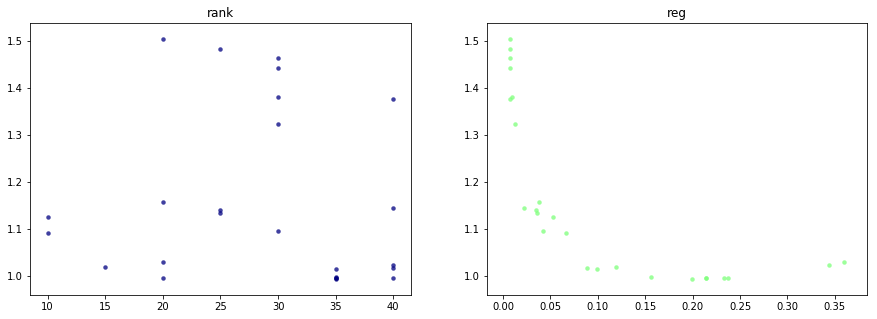

In [39]:
parameters = ['rank', 'reg']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)

It can be seen from the above plot that
* The actual impact of rank is in line with the intuition - the smaller the value the better the result.
* It is interesting to see that the optimal value of reg is around 0.1 to 0.15. 

Get the best model.

In [40]:
als = ALS(
    rank=best["rank"],
    regParam=best["reg"],
    maxIter=15,
    implicitPrefs=False,
    alpha=0.1,
    coldStartStrategy='drop',
    nonnegative=False,
    seed=42,
    **HEADER_ALS
)
    
model_best_hyperopt = als.fit(train)

Tuning prameters against other metrics can be simply done by modifying the `objective` function. The following shows an objective function of how to tune "precision@k". Since `fmin` in `hyperopt` only supports minimization while the actual objective of the loss is to maximize "precision@k", `-precision` instead of `precision` is used in the returned value of the `objective` function.

In [41]:
# Customize an objective function
def objective_precision(params):
    time_run_start = time.time()
    
    rank = params['rank']
    reg = params['reg']
    train = params['train'] 
    valid = params['valid'] 
    col_user = params['col_user'] 
    col_item = params['col_item']
    col_rating = params['col_rating'] 
    col_prediction = params['col_prediction'] 
    k = params['k']
    relevancy_method = params['relevancy_method']
    
    header = {
        "userCol": col_user,
        "itemCol": col_item,
        "ratingCol": col_rating,
    }
    
    als = ALS(
        rank=rank,
        maxIter=15,
        implicitPrefs=False,
        alpha=0.1,
        regParam=reg,
        coldStartStrategy='drop',
        nonnegative=False,
        seed=42,
        **header
    )
    
    model = als.fit(train)
    
    users = train.select(col_user).distinct()
    items = train.select(col_item).distinct()
    user_item = users.crossJoin(items)
    dfs_pred = model.transform(user_item)

    # Remove seen items.
    dfs_pred_exclude_train = dfs_pred.alias("pred").join(
        train.alias("train"),
        (dfs_pred[col_user] == train[col_user]) & (dfs_pred[col_item] == train[col_item]),
        how='outer'
    )

    top_all = dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull()) \
        .select('pred.' + col_user, 'pred.' + col_item, 'pred.' + "prediction")
    
    top_all.cache().count()

    rank_eval = SparkRankingEvaluation(
        valid, 
        top_all, 
        k=k, 
        col_user=col_user, 
        col_item=col_item, 
        col_rating="rating", 
        col_prediction="prediction", 
        relevancy_method=relevancy_method
    )
    
    precision = rank_eval.precision_at_k()
    
    # Return the objective function result.
    return {
        'loss': -precision,
        'status': STATUS_OK,
        'eval_time': time.time() - time_run_start
    }

### 4.2 Hyperparameter tuning with `hyperopt` sampling methods

Though `hyperopt` works well in a single node machine, its features (e.g., `Trials` module) do not support Spark environment, which makes it hard to perform the tuning tasks in a distributed/parallel manner. It is useful to use `hyperopt` for sampling parameter values from the pre-defined sampling space, and then parallelize the model training onto Spark cluster with the sampled parameter combinations.

The downside of this method is that the intelligent searching algorithm (i.e., TPE) of `hyperopt` cannot be used. The approach introduced here is therefore equivalent to random search.

Sample the parameters used for model building from the pre-defined space. 

In [42]:
time_start = time.time()

sample_params = [sample(space) for x in range(NUMBER_ITERATIONS)]

The following runs model building on the sampled parameter values with the pre-defined objective function.

In [43]:
results_map = list(map(lambda x: objective(x), sample_params))

time_sample = time.time() - time_start

In [44]:
results_map

[{'eval_time': 9.228703737258911, 'loss': 1.243529154696868, 'status': 'ok'},
 {'eval_time': 8.888501405715942, 'loss': 1.2588926819847364, 'status': 'ok'},
 {'eval_time': 9.302585124969482, 'loss': 1.2774762839323814, 'status': 'ok'},
 {'eval_time': 9.685980558395386, 'loss': 1.331848687427348, 'status': 'ok'},
 {'eval_time': 9.406116485595703, 'loss': 1.0108710014765308, 'status': 'ok'},
 {'eval_time': 8.555379152297974, 'loss': 1.1783174514771158, 'status': 'ok'},
 {'eval_time': 9.012490034103394, 'loss': 1.3693498595254936, 'status': 'ok'},
 {'eval_time': 9.189195394515991, 'loss': 1.0135247677787642, 'status': 'ok'},
 {'eval_time': 9.49919867515564, 'loss': 1.2330311529100353, 'status': 'ok'},
 {'eval_time': 8.681516647338867, 'loss': 0.9942520594566032, 'status': 'ok'},
 {'eval_time': 9.14221453666687, 'loss': 1.0537896241605391, 'status': 'ok'},
 {'eval_time': 9.085102796554565, 'loss': 1.3861387682130617, 'status': 'ok'},
 {'eval_time': 9.387271642684937, 'loss': 1.023577382516

Get the best model.

In [45]:
loss_metrics = np.array([x['loss'] for x in results_map])
best_loss = np.where(loss_metrics == min(loss_metrics))

In [46]:
best_param = sample_params[best_loss[0].item()]

In [47]:
als = ALS(
    rank=best_param["rank"],
    regParam=best_param["reg"],
    maxIter=15,
    implicitPrefs=False,
    alpha=0.1,
    coldStartStrategy='drop',
    nonnegative=False,
    seed=42,
    **HEADER_ALS
)
    
model_best_sample = als.fit(train)

## 5 Evaluation on testing data

The optimal parameters can then be used for building a recommender, which is then evaluated on the testing data.

The following codes generate the evaluation results by using the testing dataset with the optimal model selected against the pre-defined loss. Without loss of generity, in this case, the optimal model that performs the best w.r.t regression loss (i.e., the RMSE metric) is used. One can simply use other metrics like precision@k, as illustrated in the above sections, to evaluate the optimal model on the testing dataset.

In [48]:
# Get prediction results with the optimal modesl from different approaches.
prediction_spark = model_best_spark.transform(test)
prediction_hyperopt = model_best_hyperopt.transform(test)
prediction_sample = model_best_sample.transform(test)

predictions = [prediction_spark, prediction_hyperopt, prediction_sample]
elapsed = [time_spark, time_hyperopt, time_sample]

approaches = ['spark', 'hyperopt', 'sample']
test_evaluations = pd.DataFrame()
for ind, approach in enumerate(approaches):    
    rating_eval = SparkRatingEvaluation(
        test, 
        predictions[ind],
        **HEADER
    )
    
    result = pd.DataFrame({
        'Approach': approach,
        'RMSE': rating_eval.rmse(),
        'MAE': rating_eval.mae(),
        'Explained variance': rating_eval.exp_var(),
        'R squared': rating_eval.rsquared(),
        'Elapsed': elapsed[ind]
    }, index=[0])
    
    test_evaluations = test_evaluations.append(result)

In [49]:
test_evaluations

,Approach,Elapsed,Explained variance,MAE,R squared,RMSE
0,spark,123.962629,0.291124,0.777012,0.252323,0.976337
0,hyperopt,233.240675,0.298655,0.789633,0.240799,0.983681
0,sample,231.161446,0.297190,0.791277,0.238699,0.985041


From the results, it can be seen that, *with the same number of iterations*, Spark native construct based approach takes the least amount of time, even if there is no parallel computing. This is simply because Spark native constructs leverage the underlying Java codes for running the actual analytics with high performance efficiency. Interestingly, the run time for `hyperopt` with TPE algorithm and random search methods are almost the same. Possible reasons for this are that, the TPE algorithm searches optimal parameters intelligently but runs the tuning iterations sequentially. Also, the advantage of TPE may become obvious when there is a higher dimensionality of hyperparameters. 

The three approaches use the same RMSE loss. In this measure, the native Spark construct performs the best. The `hyperopt` based approach performs the second best, but the advantage is very subtle. It should be noted that these differences may be owing to many factors like characteristics of datasets, dimensionality of hyperparameter space, sampling size in the searching, etc. Note the differences in the RMSE metrics may also come from the randomness of the intermediate steps in parameter tuning process. In practice, multiple runs are required for generating statistically robust comparison results. We have tried 5 times for running the same comparison codes above. The results aligned well with each other in terms of objective metric values and elapsed time. 

# Conclusions

In summary, there are mainly three different approaches for running hyperparameter tuning for Spark based recommendation algorithm. The three different approaches are compared as follows.

|Approach|Distributed (on Spark)|Param sampling|Advanced hyperparam searching algo|Custom evaluation metrics|Custom data split|
|---------|-------------|--------------|--------------------------|--------------|------------|
|AzureML Services|Parallelizing Spark sessions on multi-node cluster or single Spark session on one VM node.)|Random, Grid, Bayesian sampling for discrete and continuous variables.|Bandit policy, Median stopping policy, and truncation selection policy.|Yes|Yes|
|Spark native construct|Distributed in single-node standalone Spark environment or multi-node Spark cluster.|No|No|Need to re-engineer Spark modules|Need to re-engineer Spark modules.|
|`hyperopt`|No (only support parallelization on MongoDB)|Random sampling for discrete and continuous variables.|Tree Parzen Estimator|Yes|Yes|

In [50]:
# cleanup spark instance
spark.stop()

# References

* Azure Machine Learning Services, url: https://azure.microsoft.com/en-us/services/machine-learning-service/
* Lisa Li, *et al*, Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization, The Journal of Machine Learning Research, Volume 18 Issue 1, pp 6765-6816, January 2017.
* James Bergstrat *et al*, Algorithms for Hyper-Parameter Optimization, Procs 25th NIPS 2011. 
* `hyperopt`, url: http://hyperopt.github.io/hyperopt/.
* Bergstra, J., Yamins, D., Cox, D. D. (2013) Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures. Proc. of the 30th International Conference on Machine Learning (ICML 2013).
* Kris Wright, "Hyper parameter tuning with hyperopt", url:https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt